In [1]:
from scipy import integrate
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import animation

import numpy as np

from ipywidgets import interact, fixed

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
######## Reaction Details ########
m_n = 1                 # mass of nucleon in MeV/c^2
hbar = 1               # hbar in MeV fm/c
E = 10                            # energy in the center of mass frame

############### Grid ###############
dr    = 0.1                       # spatial separation in fm
r     = np.arange(0, 300, dr)  # spatial grid points

###### Initial Wave Function ######
s    = 2                        # width of initial gaussian wave-packet
r0   = 30.0                     # center of initial gaussian wave-packet

######### Calculated Constants ####
a = 1.0 / (s * np.sqrt(np.pi))    # normalization constant
k = np.sqrt(2 * m_n * E) / hbar    # wave number

###### Initial Wavefunction #######
psi0 = np.sqrt(a) * np.exp(-(r - r0)**2 / (2.0 * s**2)) * np.exp(1j * k * r)

####### Potential Function ########
Vs = 1                           # potential in MeV
def potential_well(r):
    V = np.zeros_like(r)
    V[np.abs(r) > 15] = 0
    V[np.abs(r) <= 15] = -Vs
    return V

def potential_barrier(r):
    V = np.zeros_like(r)
    V[np.abs(r) > 15] = 0
    V[np.abs(r) <= 15] = Vs
    return V

def potential_coulomb(r):
    V = np.zeros_like(r)
    V[np.abs(r) > 15] = 2 * Vs / np.abs(r[np.abs(r) > 15] - 14.9)
    V[np.abs(r) <= 15] = - Vs
    return V

V_well = potential_well(r)
V_barrier = potential_barrier(r)
V_coulomb = potential_coulomb(r)

In [3]:
# Laplace Operator (Finite Difference)
d2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(r.size, r.size)) / dr**2

def schrodinger_well(t, psi):
    return 1j * (-0.5 * hbar**2 / m_n * d2.dot(psi) + V_well / hbar * psi)

def schrodinger_barrier(t, psi):
    return 1j * (-0.5 * hbar**2 / m_n * d2.dot(psi) + V_barrier / hbar * psi)

def schrodinger_coulomb(t, psi):
    return 1j * (-0.5 * hbar**2 / m_n * d2.dot(psi) + V_coulomb / hbar * psi)    

def schrodinger_free(t, psi):
    return 1j * (-0.5 * hbar**2 / m_n * d2.dot(psi))

In [4]:
dt = 0.1                        # time interval for snapshots
t0 = 0.0                        # initial time
tf = 30.0                       # final time
t_eval = np.arange(t0, tf, dt)  # time grid

# Solve the Initial Value Problem
sol_well = integrate.solve_ivp(schrodinger_well, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")
sol_barrier = integrate.solve_ivp(schrodinger_barrier, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")
sol_coulomb = integrate.solve_ivp(schrodinger_coulomb, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")
sol_free = integrate.solve_ivp(schrodinger_free, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")

In [5]:
# Make an interactive plot where you can select the time with a slider
def plot_wavefunction(t, sol, V, scale=1):
    t = np.argmin(np.abs(sol.t - t))
    plt.plot(r, 10 * np.abs(sol.y[:,t])**2, label=r"$\vert\psi(t,x)\vert^2$")
    plt.plot(r, 10 * np.abs(sol_free.y[:,t])**2, label=r"$\vert\psi(t,x)\vert^2$ - Free Particle")
    #plt.plot(r, 10*np.real(sol.y[:,t]) + E / Vs , "r", label=r"$\psi(t,x)$")
    #plt.plot(r, 10*np.real(sol_free.y[:,t]) + E / Vs , "b", label=r"$\psi(t,x)$ Free Particle")
    plt.plot(r, V / Vs / scale, "k--", label=r"$V(r)$")
    plt.legend(loc=1, fontsize=8, fancybox=False)
    plt.xlabel('r (fm)')
    plt.ylabel('Probability Density (fm$^{-1}$)')
    plt.xlim(0, 100)
    plt.title(r"$t = %.2f$" % sol.t[t])
    plt.show()

In [6]:
def create_gif( sol, V, label, scale=1 ):

    fig = plt.figure()
    ax1 = plt.subplot(1,1,1)
    ax1.set_xlim(0, 100)
    title = ax1.set_title('')
    line1, = ax1.plot([], [], "k--")
    line2, = ax1.plot([], [])
    line3, = ax1.plot([], [])

    # Calculate the ylim
    y_free = 10 * np.abs(sol_free.y[:,0])**2
    array = np.concatenate((V / scale, y_free))

    ymax = np.max(array) * 1.05
    ymin = np.min(array) * 1.05
    ax1.set_ylim(ymin, ymax)

    ax1.set_xlabel('r (fm)')
    ax1.set_ylabel('Probability Density (fm$^{-1}$)')

    ax1.legend([line1, line2, line3], [r"$V(r)$", r"$\vert\psi(t,x)\vert^2$", r"$\vert\psi(t,x)\vert^2$ - Free Particle"], loc=1, fontsize=8, fancybox=False)

    def init():
        line1.set_data(r, V / scale)
        return line1,

    def animate(i):
        line2.set_data(r, 10 * np.abs(sol.y[:,i])**2)
        line3.set_data(r, 10 * np.abs(sol_free.y[:,i])**2)
        title.set_text('Time = {0:1.3f}'.format(sol.t[i]))
        return line1,

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t), interval=50, blit=True)

    # Save the animation into a short video
    anim.save('gifs/{}.gif'.format(label), writer='imagemagick', fps=15, dpi=150)

In [7]:
interact(plot_wavefunction, t=(t0,tf,dt), sol=fixed(sol_well), V=fixed(V_well), scale=fixed(1))

interactive(children=(FloatSlider(value=15.0, description='t', max=30.0), Output()), _dom_classes=('widget-int…

<function __main__.plot_wavefunction(t, sol, V, scale=1)>

In [8]:
interact(plot_wavefunction, t=(t0,tf,dt), sol=fixed(sol_barrier), V=fixed(V_barrier), scale=fixed(1))

interactive(children=(FloatSlider(value=15.0, description='t', max=30.0), Output()), _dom_classes=('widget-int…

<function __main__.plot_wavefunction(t, sol, V, scale=1)>

In [9]:
interact(plot_wavefunction, t=(t0,tf,dt), sol=fixed(sol_coulomb), V=fixed(V_coulomb), scale=fixed(4))

interactive(children=(FloatSlider(value=15.0, description='t', max=30.0), Output()), _dom_classes=('widget-int…

<function __main__.plot_wavefunction(t, sol, V, scale=1)>

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


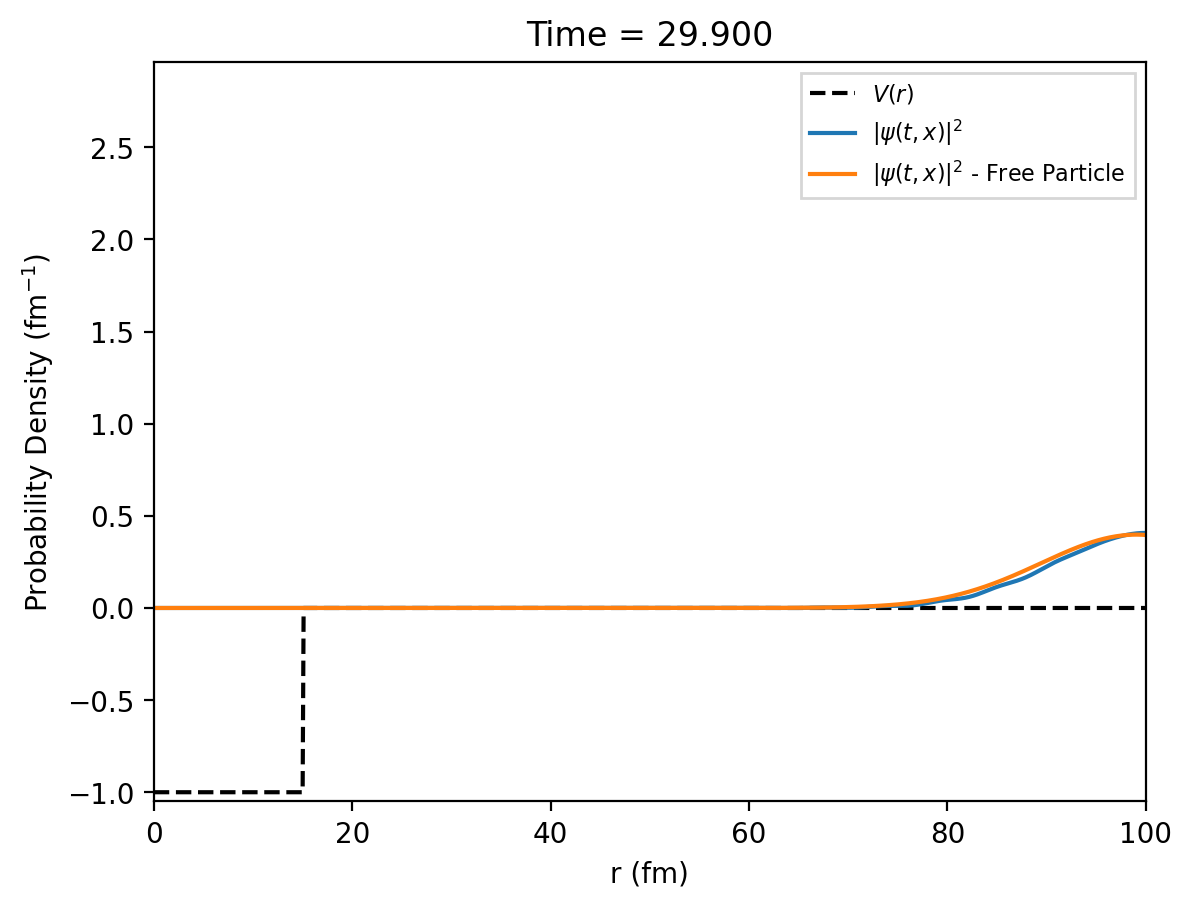

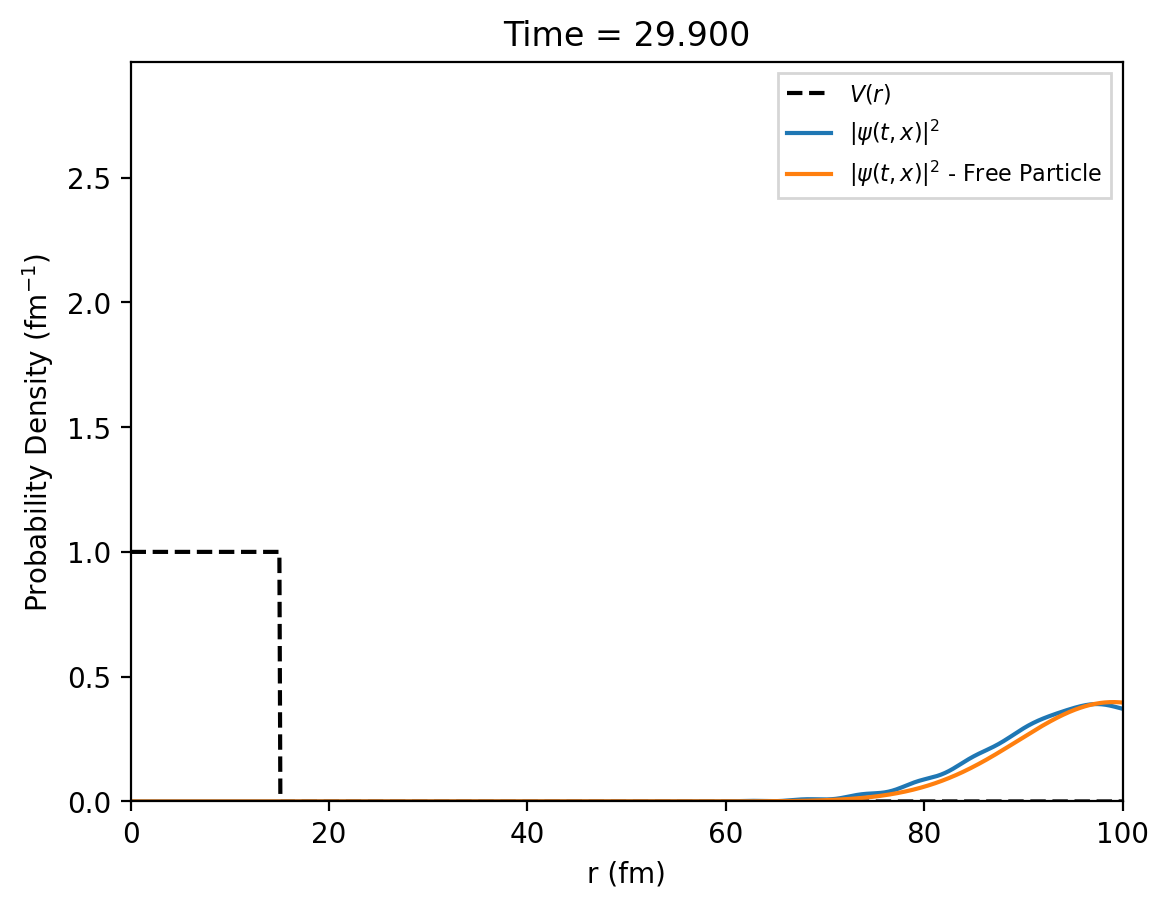

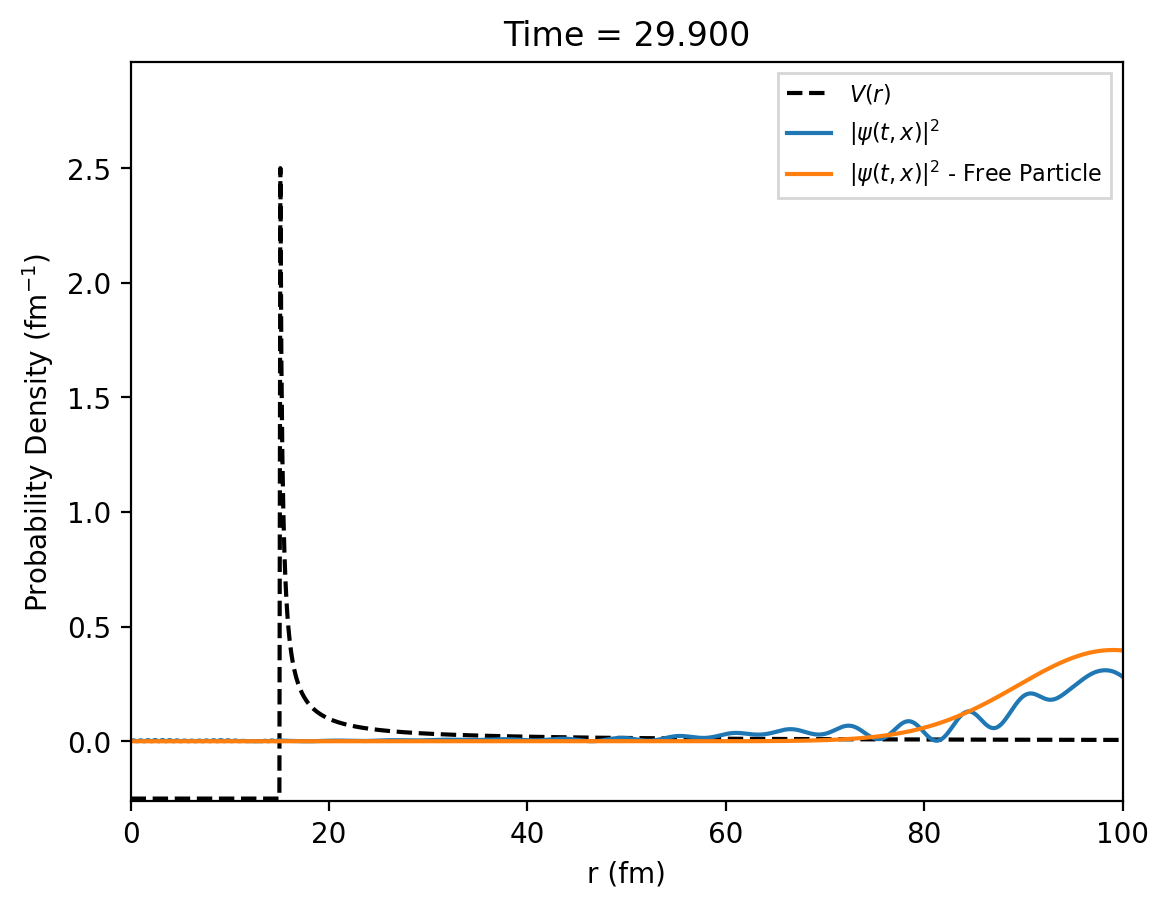

In [10]:
create_gif(sol_well, V_well, "well")
create_gif(sol_barrier, V_barrier, "barrier")
create_gif(sol_coulomb, V_coulomb, "coulomb", scale=4)